# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Host Id                     30478 non-null  int64  
 1   Host Since                  30475 non-null  object 
 2   Name                        30478 non-null  object 
 3   Neighbourhood               30478 non-null  object 
 4   Property Type               30475 non-null  object 
 5   Review Scores Rating (bin)  22155 non-null  float64
 6   Room Type                   30478 non-null  object 
 7   Zipcode                     30344 non-null  float64
 8   Beds                        30393 non-null  float64
 9   Number of Records           30478 non-null  int64  
 10  Number Of Reviews           30478 non-null  int64  
 11  Price                       30478 non-null  object 
 12  Review Scores Rating        22155 non-null  float64
dtypes: float64(4), int64(3), object

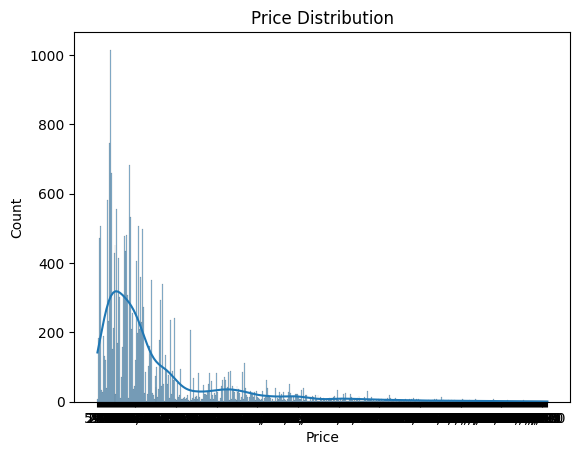

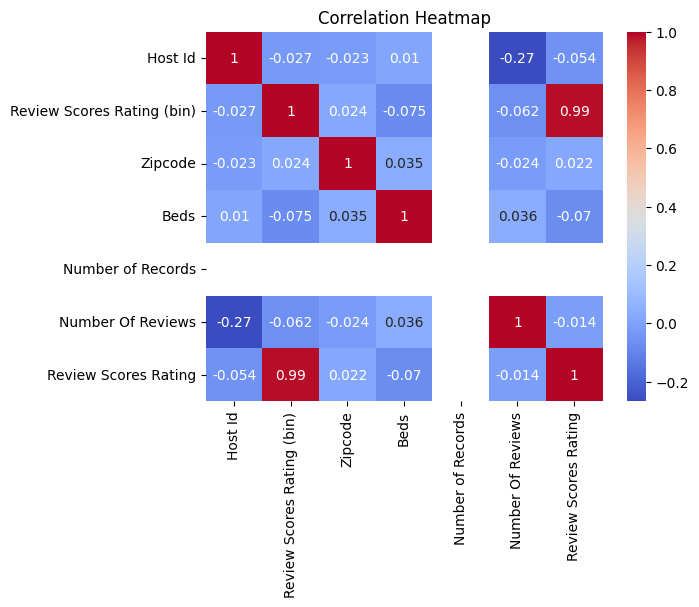

In [1]:
#1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

df = pd.read_csv("https://raw.githubusercontent.com/Lisabyy/linearModels/refs/heads/main/lab/data/airbnb_hw.csv")

print(df.info())
df = df.dropna()
df = df.drop_duplicates()

print(df.describe())
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [2]:
#2
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
y = df['Price']
X = df.drop('Price', axis=1)

X_encoded = pd.get_dummies(X, drop_first=True)

In [3]:
#3
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [4]:
print("X_train shape:", X_train.shape)

X_train shape: (17605, 23698)


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [5]:
#4
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train_pca, y_train)
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

print("Ridge Regression with PCA Results")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Train R²:", r2_score(y_train, y_pred_train))
print("Test R²:", r2_score(y_test, y_pred_test))

Ridge Regression with PCA Results
Train RMSE: 126.39992310153328
Test RMSE: 131.3138908530592
Train R²: 0.26726241309435206
Test R²: 0.2747687904221505


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.38023e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


The test model does the best based on R-square value.

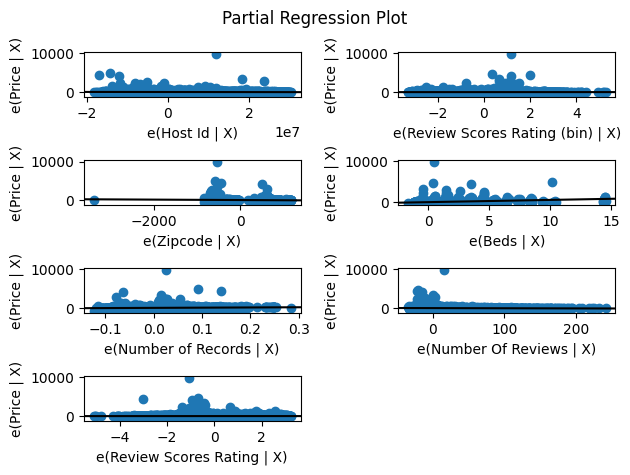

In [6]:
#5
# Select numeric columns only (excluding 'Price')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Price' in numeric_cols:
    numeric_cols.remove('Price')

# Build model with numeric features only
X_numeric = df[numeric_cols]
X_numeric = sm.add_constant(X_numeric)
y_numeric = df['Price']

# Fit OLS model
model_numeric = sm.OLS(y_numeric, X_numeric).fit()

# Generate partial regression plots
fig = sm.graphics.plot_partregress_grid(model_numeric)
plt.tight_layout()
plt.show()

It appears that all the numeric variables display linearity.

In [ ]:
#6
# Copy original DataFrame
df_trans = df.copy()

# Transformations (check for presence)
if 'Beds' in df_trans.columns:
    df_trans['log_beds'] = np.log1p(df_trans['Beds'])
    df_trans['price_x_beds'] = df_trans['Price'] * df_trans['Beds']

# Define X and y
y = df_trans['Price']
X = df_trans.drop('Price', axis=1)

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ridge Regression model
model_complex = Ridge()
model_complex.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = model_complex.predict(X_train)
y_pred_test = model_complex.predict(X_test)

# Results
print("Complex Model Results (Ridge)")
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2))
print("Test RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2))
print("Train R²:", round(r2_score(y_train, y_pred_train), 3))
print("Test R²:", round(r2_score(y_test, y_pred_test), 3))

7. From EDA, it's observed that prices are positively skewed, with variables including beds and number of reviews being potentially predictive. By adding transformations and intereactions, the predictive power is largely enhanced. The main takeaway is that simple linear regression underfit as non-linear relationships are omitted, and complex regerssion risk overfit.